Packages

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import datetime
import matplotlib.pyplot as plt

Data

In [ ]:
batch = 128

transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Lambda(lambda x: x.round())])

train_set = torchvision.datasets.MNIST(root="./data",
                                       train=True,
                                       download=True,
                                       transform=transform)

trainloader = torch.utils.data.DataLoader(train_set,
                                          batch_size=batch,
                                          shuffle=True,
                                          num_workers=2)

Network

In [ ]:
class MaskedConv(nn.Conv2d):
  def __init__(self, mask_type, *args, **kwargs):
    assert mask_type=="A" or mask_type=="B"
    super().__init__(*args, **kwargs)
    self.mask = self.register_buffer('mask', torch.zeros_like(self.weight))
    self.create_mask(mask_type)

  def create_mask(self, mask_type):
    self.mask = torch.zeros_like(self.weight)
    self.mask[:, :, :self.kernel_size[0]//2, :] = 1
    self.mask[:, :, self.kernel_size[0]//2, :self.kernel_size[1]//2] = 1
    if mask_type=="B":
      self.mask[:, :, self.kernel_size[0]//2, self.kernel_size[1]//2] = 1

  def forward(self, x):
    return F.conv2d(x, self.mask*self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

In [ ]:
class PixelCNN(nn.Module):
  def __init__(self, input_size, device):
    super().__init__()
    self.input_size = input_size
    self.device = device
    self.net = nn.Sequential(MaskedConv('A', self.input_size[0], 64, 7, padding=3),
                             nn.ReLU(),
                             MaskedConv('B', 64, 64, 7, padding=3),
                             nn.ReLU(),
                             MaskedConv('B', 64, 64, 7, padding=3),
                             nn.ReLU(),
                             MaskedConv('B', 64, 64, 7, padding=3),
                             nn.ReLU(),
                             MaskedConv('B', 64, self.input_size[0], 7, padding=3))

  def forward(self, x):
    x = self.net(x)
    probs = F.sigmoid(x)
    return probs

  def sample(self, n):
    x = torch.zeros(n, self.input_size[0], self.input_size[1], self.input_size[2]).to(self.device)
    with torch.no_grad():
      for i in range(self.input_size[1]):
        for j in range(self.input_size[2]):
          probs = self.forward(x)
          x[:, :, i, j] = torch.bernoulli(probs[:, :, i, j])

    return x.cpu()

Init model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PixelCNN((1, 28, 28), device).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

Training Loop

Epoch 1, Step [100/469], Time 2023-07-05 16:25:09.952660, Loss 0.13009986281394958
Epoch 1, Step [200/469], Time 2023-07-05 16:25:17.962096, Loss 0.10548702627420425
Epoch 1, Step [300/469], Time 2023-07-05 16:25:26.065454, Loss 0.09169004112482071
Epoch 1, Step [400/469], Time 2023-07-05 16:25:34.307767, Loss 0.09308376908302307
Epoch 2, Step [100/469], Time 2023-07-05 16:25:50.983892, Loss 0.09045848250389099
Epoch 2, Step [200/469], Time 2023-07-05 16:25:58.359138, Loss 0.08862515538930893
Epoch 2, Step [300/469], Time 2023-07-05 16:26:05.565471, Loss 0.08740294724702835
Epoch 2, Step [400/469], Time 2023-07-05 16:26:12.916917, Loss 0.09232326596975327
Epoch 3, Step [100/469], Time 2023-07-05 16:26:25.546961, Loss 0.08867528289556503
Epoch 3, Step [200/469], Time 2023-07-05 16:26:33.004668, Loss 0.08971806615591049
Epoch 3, Step [300/469], Time 2023-07-05 16:26:40.570516, Loss 0.08718797564506531
Epoch 3, Step [400/469], Time 2023-07-05 16:26:48.128779, Loss 0.08732987940311432
Epoc

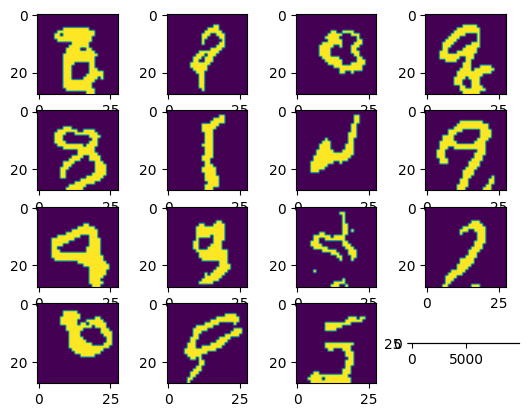

In [ ]:
epochs = 20
loss_values = []
for epoch in range(1, epochs+1):
  for i, (imgs, _) in enumerate(trainloader):
    x = imgs.to(device)
    probs = model(x)

    loss = F.binary_cross_entropy(probs, x)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())

    if (i+1)%100==0:
      print(f'Epoch {epoch}, Step [{i+1}/{len(trainloader)}], Time {datetime.datetime.now()}, Loss {loss.item()}')

  if epoch in [1, 4, 10, 14, 18, 20]:
    torch.save(model.state_dict(), f'/content/pixelcnn_epoch{epoch}.pth')
    samples = model.sample(16)
    for j in range(16):
      plt.subplot(4, 4, j+1)
      plt.imshow(samples[j, :, :, :].view(1, 28, 28).permute(1, 2, 0).numpy())
    plt.savefig(f'/content/sampled_imgs_epoch{epoch}.png')

print('Finish training')
plt.plot(loss_values)
plt.savefig('/content/loss_function.png')